##### 1. загрузка processed и split

In [43]:
import pandas as pd
import plt
from sklearn.model_selection import train_test_split

df = pd.read_csv("../ml/data/processed/hr_processed.csv")
df = df.drop_duplicates()

X = df.drop(columns=["Attrition", "target"])
y = df["target"]
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

row_leave = X[df["target"] == 0].iloc[0].to_dict()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_hash = pd.util.hash_pandas_object(X_train, index=False)
test_hash  = pd.util.hash_pandas_object(X_test, index=False)

print("duplicates across split:", test_hash.isin(train_hash).sum(), "of", len(X_test))

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


X.shape: (8594, 33), y.shape: (8594,)
duplicates across split: 2 of 1719


((6875, 33),
 (1719, 33),
 np.float64(0.16465454545454544),
 np.float64(0.16463059918557302))

##### 2. подготовка признаков

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
])

len(cat_cols), len(num_cols), cat_cols[:5], num_cols[:5]

(8,
 25,
 ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole'],
 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount'])

##### 3. Утилиты

In [45]:
import json
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def _get_scores(pipe, X):
    if hasattr(pipe, "predict_proba"):
        return pipe.predict_proba(X)[:, 1]
    if hasattr(pipe, "decision_function"):
        return pipe.decision_function(X)
    return pipe.predict(X)


def eval_model(name, pipe, X_test, y_test, threshold=0.5):
    scores = _get_scores(pipe, X_test)
    if hasattr(pipe, "predict_proba"):
        pred = (scores >= threshold).astype(int)
    else:
        pred = (scores >= 0).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    return {
        "model": name,
        "threshold": threshold if hasattr(pipe, "predict_proba") else 0.0,
        "pr_auc": average_precision_score(y_test, scores),
        "roc_auc": roc_auc_score(y_test, scores),
        "f1": f1_score(y_test, pred),
        "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
        "alerts_total": int(tp + fp),
        "caught": f"{int(tp)}/{int(tp+fn)}",
    }

def eval_pipe(name, pipe, X_test, y_test, threshold: float):
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= threshold).astype(int)
    pr_auc = average_precision_score(y_test, proba)
    roc_auc = roc_auc_score(y_test, proba)
    f1 = f1_score(y_test, pred)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    res = {
        "model": name,
        "threshold": float(threshold),
        "pr_auc": float(pr_auc),
        "roc_auc": float(roc_auc),
        "f1": float(f1),
        "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
    }

    print(f"\n=== {name} | threshold={threshold:.2f} ===")
    print(classification_report(y_test, pred, digits=4))
    return res

def fit_and_eval(name, model, preprocess, X_train, y_train, X_test, y_test, threshold=0.5):
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    res = eval_model(name, pipe, X_test, y_test, threshold=threshold)
    return res, pipe

def fir_and_eval_tune_hpd(name, model, preprocess, X_train, y_train, X_test, y_test, threshold=0.5):
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    res = eval_model(name, pipe, X_test, y_test, threshold=threshold)
    return res, pipe

def eval_and_plot(name, pipe, X_test, y_test, threshold: float):
    proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} | threshold={threshold:.2f} | accuracy={acc:.4f} ===")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


##### 4. LogReg

In [46]:
from sklearn.linear_model import LogisticRegression

lr_res, lr_pipe = fit_and_eval(
    "LogReg",
    LogisticRegression(max_iter=10000, solver="lbfgs", class_weight="balanced"),
    preprocess, X_train, y_train, X_test, y_test, threshold=0.5
)

pd.DataFrame([lr_res]).round(4)
lr_res

{'model': 'LogReg',
 'threshold': 0.5,
 'pr_auc': 0.4103498701297402,
 'roc_auc': 0.7419338169434136,
 'f1': 0.4129032258064516,
 'tp': 192,
 'fp': 455,
 'fn': 91,
 'tn': 981,
 'alerts_total': 647,
 'caught': '192/283'}

In [58]:
# 4.1 Тюнинг и оценка модели (Logistic Regression)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
import pandas as pd

# --- 1️⃣ Задаем сетку параметров ---
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "lbfgs"],
}

log_reg = LogisticRegression(max_iter=10000, class_weight="balanced")

# --- 2️⃣ Grid Search (перебор всех комбинаций) ---
grid_search = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

print("\nBest Parameters from GridSearchCV:")
print(grid_search.best_params_)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")

# --- 3️⃣ Randomized Search (случайные комбинации, быстрее) ---
random_search = RandomizedSearchCV(
    log_reg,
    param_grid,
    n_iter=7,
    cv=5,
    random_state=42,
    scoring="f1",
)
random_search.fit(X_train, y_train)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best Cross-Validation Score: {random_search.best_score_:.2f}")

# --- 4️⃣ Кросс-валидация на лучших параметрах ---
best_lr = grid_search.best_estimator_
cv_scores = cross_val_score(best_lr, X_train, y_train, cv=5, scoring="recall")

print("\nCross-validation Recall Scores:", cv_scores)
print(f"Mean Cross-validation Recall: {cv_scores.mean():.2f}")

# --- 5️⃣ Обучаем модель с лучшими параметрами ---
best_lr_res, best_lr_pipe = fit_and_eval(
    "Tuned_LogReg",
    best_lr,
    preprocess,
    X_train,
    y_train,
    X_test,
    y_test,
    threshold=0.5,
)

pd.DataFrame([best_lr_res]).round(4)


ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1247, in fit
    X, y = validate_data(
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1368, in check_X_y
    X = check_array(
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/pandas/core/generic.py", line 2171, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Travel_Frequently'

--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1247, in fit
    X, y = validate_data(
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1368, in check_X_y
    X = check_array(
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/pandas/core/generic.py", line 2171, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Travel_Rarely'

--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/pydev/Desktop/courses/AI-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.


##### 5. RandomForest

In [48]:
from sklearn.ensemble import RandomForestClassifier


rf_res, rf_pipe = fit_and_eval(
    "RandomForest",
    RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample",
    ),
    preprocess, X_train, y_train, X_test, y_test, threshold=0.35
)

from pathlib import Path
import joblib

BASE_DIR = Path.cwd().resolve().parent

ARTIFACTS_DIR = BASE_DIR / "ml" / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(rf_pipe, ARTIFACTS_DIR / "model.joblib")

meta = {
    "threshold": 0.35,
    "features": X_train.columns.tolist()
}
joblib.dump(meta, ARTIFACTS_DIR / "meta.joblib")
print("Saved to:", ARTIFACTS_DIR.resolve())

pd.DataFrame([rf_res]).round(4)

proba_rf = rf_pipe.predict_proba(X_test)[:, 1]
rf_results = X_test.copy()
rf_results["prob_leave"] = proba_rf
rf_results["true_label"] = y_test.values
rf_results.sort_values("prob_leave", ascending=False).head(10)
threshold = 0.35
high_risk = rf_results.query("prob_leave >= @threshold")
high_risk_top = high_risk.sort_values("prob_leave", ascending=False).head(10)

high_risk_json = high_risk_top.to_dict(orient="records")

output_path = ARTIFACTS_DIR / "high_risk_employees.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(high_risk_json, f, ensure_ascii=False, indent=2)


Saved to: /home/pydev/Desktop/courses/AI-project/ml/artifacts


In [49]:
# 1️⃣ Проверка переобучения: сравнение train и test
from sklearn.metrics import accuracy_score

# Предсказания для train и test
y_train_pred = rf_pipe.predict(X_train)
y_test_pred = rf_pipe.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))


Train accuracy: 1.0
Test accuracy: 0.9749854566608493


In [50]:
# 2️⃣ Проверка важности признаков
import pandas as pd

# Извлекаем сам RandomForest из пайплайна
rf_model = rf_pipe.steps[-1][1]

# Получаем важности
feat_names = rf_pipe[:-1].get_feature_names_out()
importances = rf_model.feature_importances_

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print("\nTop 15 important features:")
print(feat_imp.head(15))



Top 15 important features:
num__Age                        0.094720
num__DailyRate                  0.064902
num__MonthlyIncome              0.054659
num__HourlyRate                 0.050670
num__DistanceFromHome           0.048745
num__MonthlyRate                0.044175
num__TotalWorkingYears          0.040734
num__PercentSalaryHike          0.034895
num__YearsAtCompany             0.033472
num__YearsInCurrentRole         0.028163
num__YearsWithCurrManager       0.028083
num__TrainingTimesLastYear      0.024964
num__Education                  0.023496
num__StockOptionLevel           0.023104
num__YearsSinceLastPromotion    0.023029
dtype: float64


In [51]:
# 3️⃣ Проверка устойчивости через кросс-валидацию
from sklearn.model_selection import cross_val_score
import numpy as np

# Оборачиваем в пайплайн
from sklearn.pipeline import Pipeline

cv_pipe = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(max_depth=10, n_estimators=200, class_weight="balanced", random_state=42))
])

scores = cross_val_score(cv_pipe, X_train, y_train, cv=5, scoring="f1")
print("\nCross-validation F1 scores:", scores)
print("Mean F1:", np.mean(scores))
print("Std F1:", np.std(scores))



Cross-validation F1 scores: [0.77664975 0.7680798  0.76119403 0.77974684 0.79699248]
Mean F1: 0.7765325786376877
Std F1: 0.012129907874213603


##### 6. Boosting

In [52]:
from sklearn.ensemble import HistGradientBoostingClassifier


hgb_res, hgb_pipe = fit_and_eval(
    "HGB",
    HistGradientBoostingClassifier(random_state=42),
    preprocess,
    X_train, y_train, X_test, y_test,
    threshold=0.52
)
pd.DataFrame([hgb_res]).round(4)

,model,threshold,pr_auc,roc_auc,f1,tp,fp,fn,tn,alerts_total,caught
0,HGB,0.52,0.9581,0.9849,0.8008,189,0,94,1436,189,189/283


In [53]:
import numpy as np

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
hgb_pipe.fit(X_tr, y_tr)
proba_val = hgb_pipe.predict_proba(X_val)[:, 1]
hgb_pipe.fit(X_train, y_train)

best_t, best_f1 = None, -1
for t in np.linspace(0.05, 0.95, 91):
    f1 = f1_score(y_val, (proba_val >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_t = f1, t

hgb_tuned_res = eval_pipe(
    "HGB_TUNED", hgb_pipe, X_test, y_test, threshold=best_t
)
hgb_tuned_pipe = hgb_pipe

pd.DataFrame([hgb_res]).round(4)




=== HGB_TUNED | threshold=0.22 ===
              precision    recall  f1-score   support

           0     0.9852    0.9708    0.9779      1436
           1     0.8618    0.9258    0.8927       283

    accuracy                         0.9634      1719
   macro avg     0.9235    0.9483    0.9353      1719
weighted avg     0.9649    0.9634    0.9639      1719



,model,threshold,pr_auc,roc_auc,f1,tp,fp,fn,tn,alerts_total,caught
0,HGB,0.52,0.9581,0.9849,0.8008,189,0,94,1436,189,189/283


###### 7. Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

dt_res, dt_pipe = fit_and_eval(
    "DecisionTree",
    DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced",
        max_depth=8,
        min_samples_leaf=20
    ),
    preprocess, X_train, y_train, X_test, y_test, threshold=0.5
)

pd.DataFrame([dt_res]).round(4)


,model,threshold,pr_auc,roc_auc,f1,tp,fp,fn,tn,alerts_total,caught
0,DecisionTree,0.5,0.5036,0.8271,0.4833,203,354,80,1082,557,203/283


Сравнение


=== LogReg | threshold=0.50 | accuracy=0.6824 ===
              precision    recall  f1-score   support

           0     0.9151    0.6831    0.7823      1436
           1     0.2968    0.6784    0.4129       283

    accuracy                         0.6824      1719
   macro avg     0.6059    0.6808    0.5976      1719
weighted avg     0.8133    0.6824    0.7215      1719



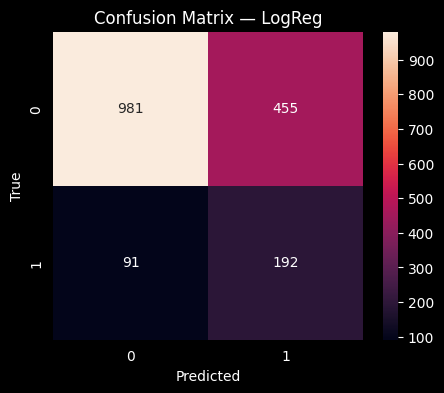


=== RandomForest | threshold=0.35 | accuracy=0.9837 ===
              precision    recall  f1-score   support

           0     0.9835    0.9972    0.9903      1436
           1     0.9848    0.9152    0.9487       283

    accuracy                         0.9837      1719
   macro avg     0.9842    0.9562    0.9695      1719
weighted avg     0.9837    0.9837    0.9835      1719



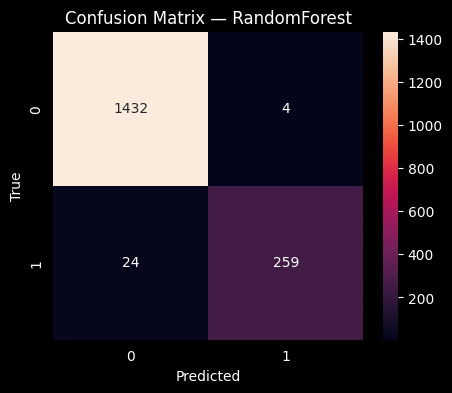


=== HGB | threshold=0.52 | accuracy=0.9453 ===
              precision    recall  f1-score   support

           0     0.9386    1.0000    0.9683      1436
           1     1.0000    0.6678    0.8008       283

    accuracy                         0.9453      1719
   macro avg     0.9693    0.8339    0.8846      1719
weighted avg     0.9487    0.9453    0.9407      1719



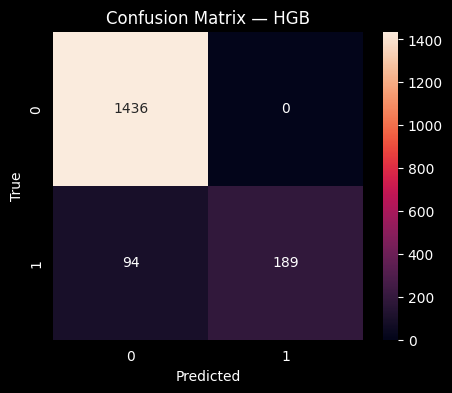


=== HGB_TUNED | threshold=0.22 | accuracy=0.9634 ===
              precision    recall  f1-score   support

           0     0.9852    0.9708    0.9779      1436
           1     0.8618    0.9258    0.8927       283

    accuracy                         0.9634      1719
   macro avg     0.9235    0.9483    0.9353      1719
weighted avg     0.9649    0.9634    0.9639      1719



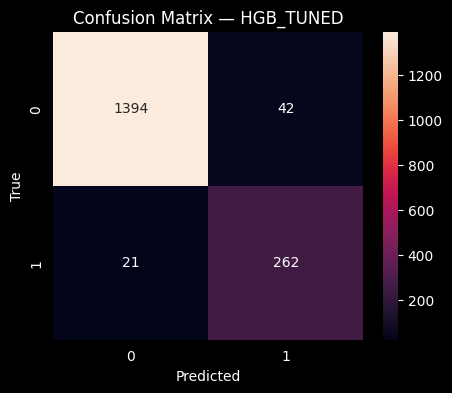


=== DecisionTree | threshold=0.50 | accuracy=0.7475 ===
              precision    recall  f1-score   support

           0     0.9312    0.7535    0.8329      1436
           1     0.3645    0.7173    0.4833       283

    accuracy                         0.7475      1719
   macro avg     0.6478    0.7354    0.6581      1719
weighted avg     0.8379    0.7475    0.7754      1719



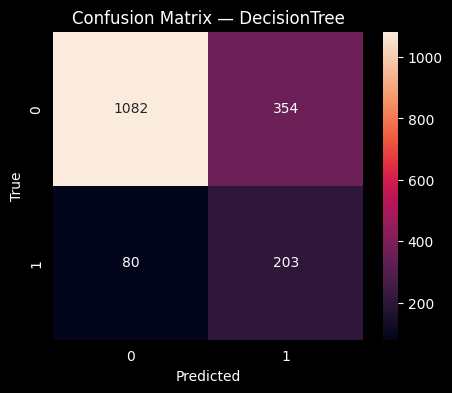

In [55]:
score_table = (pd.DataFrame([lr_res, rf_res, hgb_res, dt_res, hgb_tuned_res])
               .sort_values("pr_auc", ascending=False)
               .round(4))

score_table

models = {
    "LogReg": (lr_pipe, float(lr_res["threshold"])),
    "RandomForest": (rf_pipe, float(rf_res["threshold"])),
    "HGB": (hgb_pipe, float(hgb_res["threshold"])),
    "HGB_TUNED": (hgb_tuned_pipe, float(hgb_tuned_res["threshold"])),
    "DecisionTree": (dt_pipe, float(dt_res["threshold"])),
}

for name, (pipe, thr) in models.items():
    eval_and_plot(name, pipe, X_test, y_test, thr)
